# Evaluating the new Wikidata Infoboxes

## 1. Getting some basic informations

Before all, let remind us how many different wikipedia pages we are following
* data : page ids fr dumps  https://databus.dbpedia.org/dbpedia/generic/page/

In [7]:
from os import listdir
import subprocess
import pandas as pd
from subprocess import Popen, PIPE
file_id="/user/cringwal/home/Desktop/DBpedia_tests/AbstractEval/dbpedia_generic_page_2021.12.01_page_lang=fr_ids.ttl"
count_total=""

bashCmd = ["wc", "-l",file_id]
process = subprocess.Popen(bashCmd, stdout=subprocess.PIPE)
output, error = process.communicate()
nb_lines=int(output.split()[0])

In [244]:
print(nb_lines)

4817807


We wanted to know also which infoboxes are mapped, so we download the mappings from the DIEF github


In [21]:
import requests 
# We get the mapping file of DBpedia FR
url_mapping="https://raw.githubusercontent.com/dbpedia/extraction-framework/master/mappings/Mapping_fr.xml"
r = requests.get(url_mapping)
xml_string=r.text



We looking for every infoboxes name in the file

In [210]:
import re
list_mapped=[]
for m in re.finditer(r'<title>(.*)<\/title>', xml_string):
        list_mapped.append(m.group(1).replace("Mapping fr:","Modèle:").replace(" ","_"))

## 2. The Infoboxes pointed in the Wikipedia Infobox help section

It exists today three types of infoboxes : 
* the V2 : https://fr.wikipedia.org/wiki/Cat%C3%A9gorie:Mod%C3%A8le_infobox_V2
* the V3 : https://fr.wikipedia.org/wiki/Cat%C3%A9gorie:Mod%C3%A8le_infobox_V3
* the Lua one : https://fr.wikipedia.org/wiki/Cat%C3%A9gorie:Mod%C3%A8le_infobox_Lua

I listed every of these template in a csv file,
for every one of these we give the version (V2, V3 or Lua generated) and we say if these are dynamic or not. 

* We looking after it in the [data dumps availables on the databus](https://databus.dbpedia.org/dbpedia/generic/article-templates/) if theses template are used and how many times :

We found some duplicate, it means that the list are not really up-to-date. So we cleaned manually these rows :

In [236]:
df=pd.read_csv('/user/cringwal/home/Desktop/DBpedia_tests/WikidataEval/model_stats_clean.csv', index_col=0) 

Let's get a look on the final table

In [237]:
df

,NameModel,version,type,mapped,nb2016,nb2019,nb2020,nb2021
0,Modèle:Infobox_Abbaye_cistercienne,v2,static,0,507,573,650,748
1,Modèle:Infobox_Adhésion_à_l'Union_européenne,v2,static,0,42,62,43,43
2,Modèle:Infobox_Aéroport,v2,static,1,2465,3696,3992,4145
3,Modèle:Infobox_Aérostat,v2,static,0,58,88,61,67
4,Modèle:Infobox_Affaire_criminelle,v2,static,0,101,224,288,338
...,...,...,...,...,...,...,...,...
801,Modèle:Bases_sport,links,wikidata,0,0,80161,103410,115172
802,Modèle:Bases_tourisme,links,wikidata,0,0,1597,1888,1575
803,Modèle:Bases_transport,links,wikidata,0,0,461,485,435
804,Modèle:Bases_vie_publique,links,wikidata,0,0,8366,12906,10540


In [241]:
df['mapped'].value_counts()

0    698
1    102
Name: mapped, dtype: int64

Only 102 infoboxes are mapped... Where are other the infoboxes mapped by the DBpedia community ? 

##  3. Back on the mapped infobox

What's about the mapped infobox ? Are they all the infoboxes listed by community ? 

In [219]:
col_one_list=df['NameModel'].tolist()
only_in_mapping=set(list_mapped).difference(set(col_one_list))

In [249]:
print(len(list_mapped)," infoboxes mapped")
print(len(only_in_mapping)," mapped not in the list given on the Wikipedia help guide")


230  infoboxes mapped
128  mapped not in the list given on the Wikipedia help guide


Are theses mapped infoboxes still giving data ? We check the dump file...

In [ ]:
OIM_tab=[]
list_years=["2016","2019","2020","2021"]
file_path2="/user/cringwal/home/Desktop/DBpedia_tests/WikidataEval/templates_datasets/"

for model in only_in_mapping:
        current=[model,"undefined","undefined",1]
        for year in list_years:
            pattern='<http://fr.dbpedia.org/resource/'+corrected+'>'
            process1 = subprocess.Popen(["grep", "-o",pattern,file_path2+year+"_article-templates_lang=fr.ttl"], stdout=PIPE)
            process2 = subprocess.Popen(["wc","-l"],  stdin=process1.stdout,stdout=PIPE)
            output, error = process2.communicate()
            if(len(output)>0):
                nb_found=int(output.split()[0])    
                current.append(nb_found)
            else:
                current.append(0)
        
        OIM_tab.append(current)
        print(current)

In [222]:

dfOIM_tab = pd.DataFrame(OIM_tab, columns = ['NameModel', 'version', 'type','mapped','nb2016','nb2019','nb2020','nb2021'])
dfOIM_tab.to_csv('/user/cringwal/home/Desktop/DBpedia_tests/WikidataEval/model_OIM_stats.csv') 

===> Any of these were found in the datadump : they are not use today !

### 4. Focus on the infobox list given by the Wikipedia help guide

In [251]:
res1=df.groupby(['type']).sum()

In [252]:
df.groupby(['type']).sum()[["nb2021"]]/nb_lines

,nb2021
type,
static,0.097548
wikidata,0.320708


===> 33 % of template are about infoboxes, others are simple wiki tags

<AxesSubplot:>

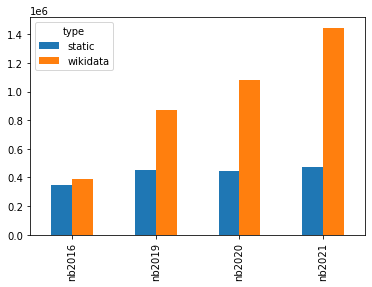

In [239]:
res1[["nb2016","nb2019","nb2020","nb2021"]].transpose().plot.bar()

Ok the situation is quite clear, since 2016, more and more infoboxes are dynamic.

<AxesSubplot:>

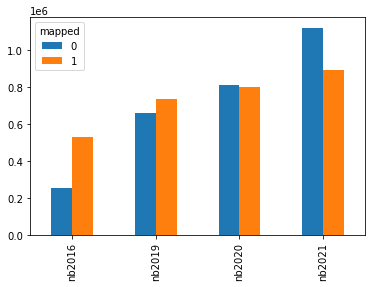

In [240]:
df.groupby(['mapped']).sum().transpose().plot.bar()

But have the Wikidata infobox pages a type ?

* We notice that the number of wikipedia page in 2016, mapped was superior of the not mapped wikipedia pages.
* In 2020 the half of the wikipedia pages were out of the focus. 
* Today we have wikipedia pages out of our focus than pages followed...
* We could also underline an general increase of wikipages in any case 

### 4. Type and dynamic infobox

In [321]:
df_wd=df[(df['type']=="wikidata")  & (df['NameModel'].str.contains("Infobox"))]
wd_models=df4.sort_values(by=['nb2021'],ascending=False)["NameModel"].tolist()
wd_models_nb_typed={}

In [336]:

tab_part=[]
for k in wd_models_nb_typed.keys():
    mapped=int(df[df['NameModel']==k]["mapped"])
    total=int(df[df['NameModel']==k]["nb2021"])
    typed=wd_models_nb_typed[k]
    
    if(total!=0):
        part=int(int(typed)/int(total)*100)
    else:
        part=0
    tab_part.append([k,mapped,total,typed,part])


In [338]:
df_typed = pd.DataFrame(tab_part, columns = ['NameModel','mapped','total','have_type','part'])

In [344]:
df_typed[(df_typed["total"]>100)].head(20)

,NameModel,mapped,total,have_type,part
0,Modèle:Infobox_Biographie2,0,271036,997,0
1,Modèle:Infobox_Localité,0,56565,1045,1
2,Modèle:Infobox_Footballeur,1,51108,51561,100
3,Modèle:Infobox_Monument,1,31795,32787,103
4,Modèle:Infobox_Artiste,1,25660,25394,98
5,Modèle:Infobox_Société,1,21456,21891,102
6,Modèle:Infobox_Cycliste,1,14196,14293,100
7,Modèle:Infobox_Personnalité_politique,1,14076,14660,104
8,Modèle:Infobox_Organisation2,0,9743,46,0
9,Modèle:Infobox_Art,1,8234,8387,101


----------> Concretly if we mapp the infobox we got a type

### 5. Properties and dynamic infoboxes

#### 5.2. raw properties 

* We called here the raw properties the properties extracted directly from the infoboxes without mapping it 

In [374]:
wd_models_nb_prop_avg2={}

In [383]:
tab_part=[]
for k in wd_models_nb_prop_avg2.keys():
    prop=wd_models_nb_prop_avg2[k]
    tab_part.append([k,float(prop)])
df_prop = pd.DataFrame(tab_part, columns = ['NameModel','prop_avg'])

In [386]:
df_prop[df_prop['prop_avg']>0].sort_values(by=['prop_avg'],ascending=False)

,NameModel,prop_avg
95,Modèle:Infobox_Parlement,33.903226
114,Modèle:Infobox_Personnage_de_One_Piece,28.333333
27,Modèle:Infobox_Descriptif_course_cycliste,28.315057
10,Modèle:Infobox_Élection,25.080589
17,Modèle:Infobox_Municipalité_du_Canada,21.497971
...,...,...
124,Modèle:Infobox_Volcan2,3.000000
67,Modèle:Infobox_Course_cycliste,2.310345
101,Modèle:Infobox_Point_de_vue_panoramique,2.250000
43,Modèle:Infobox_Plan_d'eau,2.190476


Ok we still have information filled by the Wikipedians ! If we mapp it we could be able to get it in DBpedia

#### 5.1. mapped properties 

In [346]:
wd_models_nb_prop_avg={}

In [ ]:
for m in wd_models:
    if m not in wd_models_nb_prop_avg.keys():
        endpoint2022="http://prod-dbpedia.inria.fr/sparql"
        query1='''SELECT AVG(?nb) as ?avg WHERE {SELECT ?id COUNT( DISTINCT(?p)) as ?nb FROM <http://fr.dbpedia.org/graph/dbpedia_mappings_specific-mappingbased-properties>  WHERE {
        ?id ?p ?o.
        {SELECT ?id  FROM <http://fr.dbpedia.org/graph/dbpedia_generic_article-templates> 
        WHERE { ?id ?p <http://fr.dbpedia.org/resource/'''+m+'''>}}.
        } GROUP BY ?id}''' 
        r = requests.get(endpoint2022, params = {'format': 'json', 'query': query1})
        raw_data = r.json()
        if(len(raw_data["results"]["bindings"][0].keys())>0):
            count=raw_data["results"]["bindings"][0]["avg"]["value"]
            wd_models_nb_prop_avg[m]=count
        else:
            wd_models_nb_prop_avg[m]=0
        print(m," : ",count)



In [360]:
tab_part=[]
for k in wd_models_nb_prop_avg.keys():
    mapped=int(df[df['NameModel']==k]["mapped"])
    prop=wd_models_nb_prop_avg[k]
    
    tab_part.append([k,mapped,float(prop)])
df_prop = pd.DataFrame(tab_part, columns = ['NameModel','mapped','prop_avg'])

In [372]:
df_prop[df_prop["prop_avg"]==0].shape

(129, 3)

* 129/138 doesn't have any mapped properties in average... so a majority
 * not a surprise because a majority of them are not mapped 
  * But what about mapped dynamic infoboxes ?

In [370]:
df_prop[df_prop["prop_avg"]>0]

,NameModel,mapped,prop_avg
0,Modèle:Infobox_Biographie2,0,1.000000
2,Modèle:Infobox_Footballeur,1,1.000000
6,Modèle:Infobox_Cycliste,1,2.000000
7,Modèle:Infobox_Personnalité_politique,1,1.000000
13,Modèle:Infobox_Aire_protégée,1,1.000000
20,Modèle:Infobox_Gratte-ciel,1,1.000000
22,Modèle:Infobox_Gymnaste,1,1.549451
26,Modèle:Infobox_Barrage,1,1.000000
66,Modèle:Infobox_Chanson,0,1.000000


* Ok mapping wikidata infoboxes generally give us no data... properties need to be "re-mapped"